In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

## Standard VAE + Bedford VAE

In [51]:
abspath = "./VAE_standard"

In [18]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
from treetime.utils import datetime_from_numeric
import pymc as pm
from collections.abc import Iterable
import altair as alt

import pickle
import cloudpickle
import arviz as az

In [19]:
BATCH_SIZE = 64
# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/../data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [52]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load(f"{abspath}/bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50, non_linear_activation=nn.Softplus(beta=1.0)).to(DEVICE)
vae_model.load_state_dict(torch.load(f"{abspath}/model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

VAE(
  (non_linear_activation): Softplus(beta=1.0, threshold=20)
  (encoder): Encoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): Softplus(beta=1.0, threshold=20)
    (decode): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Softplus(beta=1.0, threshold=20)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Softplus(beta=1.0, threshold=20)
      (4): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [53]:
import utils
dset = ["training", "valid", "test"]
dset = dset[0]
abspath = "."


# LOAD DATA
data_keys, data_dict = utils.get_data_dict(dset, abspath)
print(data_keys)
new_dataset = data_dict["new_dataset"]
vals = data_dict["vals"]
metadata = data_dict["metadata"]
clade_labels = data_dict["clade_labels"]
collection_dates = data_dict["collection_dates"]
indexes = data_dict["indexes"]
pairs = data_dict["pairs"]
get_parents_dict = data_dict["get_parents_dict"]

collection_dates
 [21, 54, 67, 86, 108, 140, 154, 187, 206, 220, 240, 257, 264, 275, 282, 288, 291, 308, 333, 345, 358, 369, 377, 386, 397, 408, 416, 426, 435, 461, 798, 1373, 2807, 4105, 5241, 6264, 6368]

unique clusters
 ['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']

sanity check - len(new_vals), len(vals)
 6368   6368
['new_dataset', 'vals', 'metadata', 'clade_labels', 'collection_dates', 'indexes', 'pairs', 'get_parents_dict']


In [54]:
Z_mean, Z_logvar, recon, genome, genome_recon = utils.model_eval(vae_model, new_dataset, model_type="STANDARD")
_, uniq_indices, uniq_inverse = np.unique(genome, axis=0, return_index=True, return_inverse=True)


Recon shape
torch.Size([6368, 19110])


X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])
[0.37664407 0.29631746 0.25692028 0.05689346]
total variance: 0.986775279045105


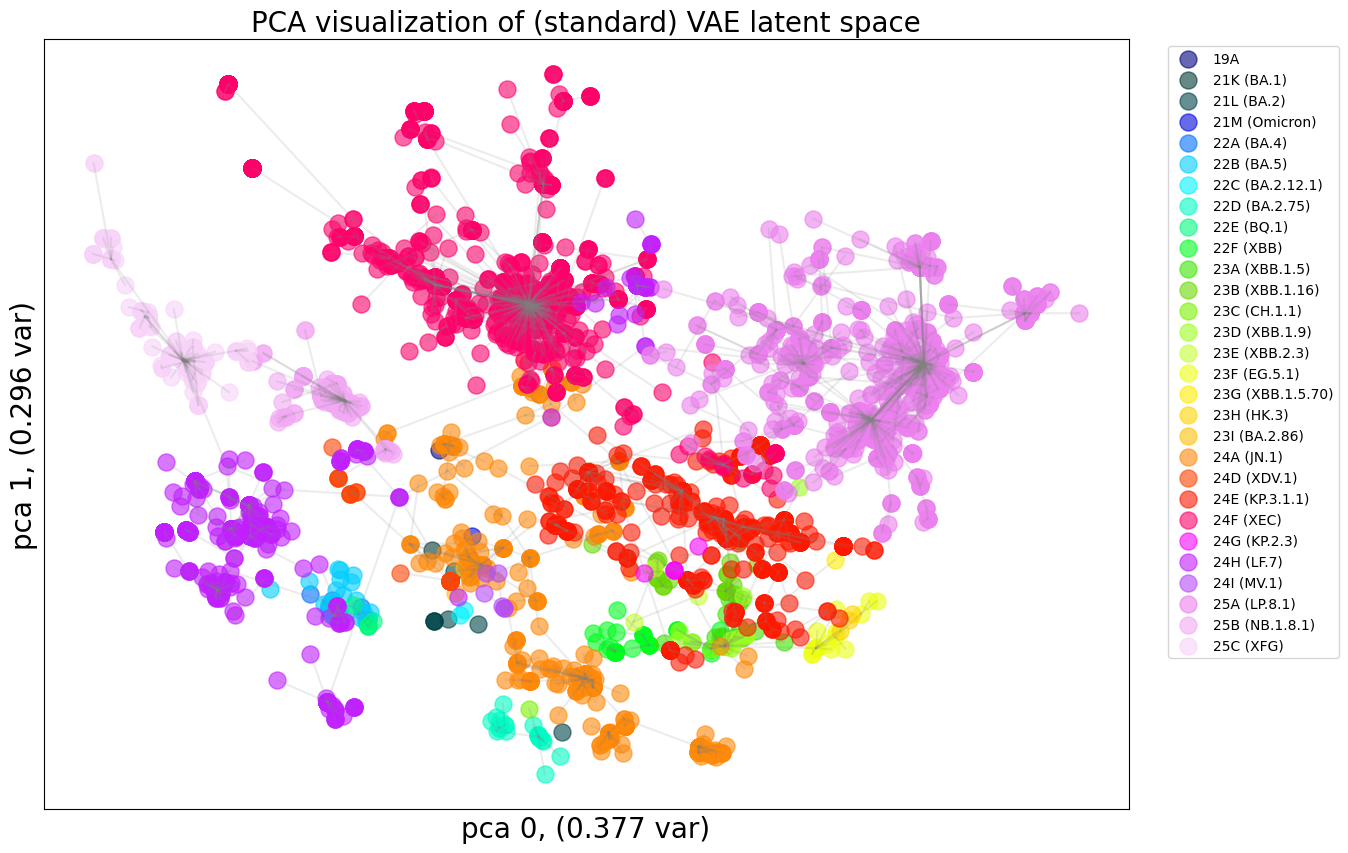

In [55]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset)
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=4, svd_solver="full")

pca.fit(Z_mean - np.mean(Z_mean))
Z_embedded = pca.transform(Z_mean - np.mean(Z_mean))
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")

# %matplotlib widget
# plt.ion()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(14,10))

# RELATIONS
curr = 0
for i,arr in enumerate(indexes):
    # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
    ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
    curr += len(arr)
l1 = 0.1
l2 = 0
ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))


# TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
# fig.colorbar(scatterplot, ax=ax, shrink=0.5)

ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(f"pca 0, (%.3f var)"%(variances[0]), fontsize=20)
ax.set_ylabel(f"pca 1, (%.3f var)"%(variances[1]), fontsize=20)
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()


In [56]:
print(pca.components_.shape)
print(pca.singular_values_)

(4, 50)
[113.37584  100.56192   93.638435  44.064224]


In [57]:
genome_uniq = genome[uniq_indices,:]
Z_mean_uniq = Z_mean[uniq_indices,:]

hamming_dists = np.sum(np.not_equal(genome_uniq[:,None,:], genome_uniq[None,:,:]), axis=-1) # returns (n,n) matrix
hamming_dists = hamming_dists[np.triu_indices(uniq_indices.shape[0], k=1)] # extract upper half elements
print("done!")

euclid_dists = np.sqrt(np.sum(np.square(Z_mean_uniq[:,None,:] - Z_mean_uniq[None,:,:]), axis=-1)) # return (n,n) matrix
euclid_dists = euclid_dists[np.triu_indices(uniq_indices.shape[0], k=1)] # extract upper half elements
print("done!")

done!
done!


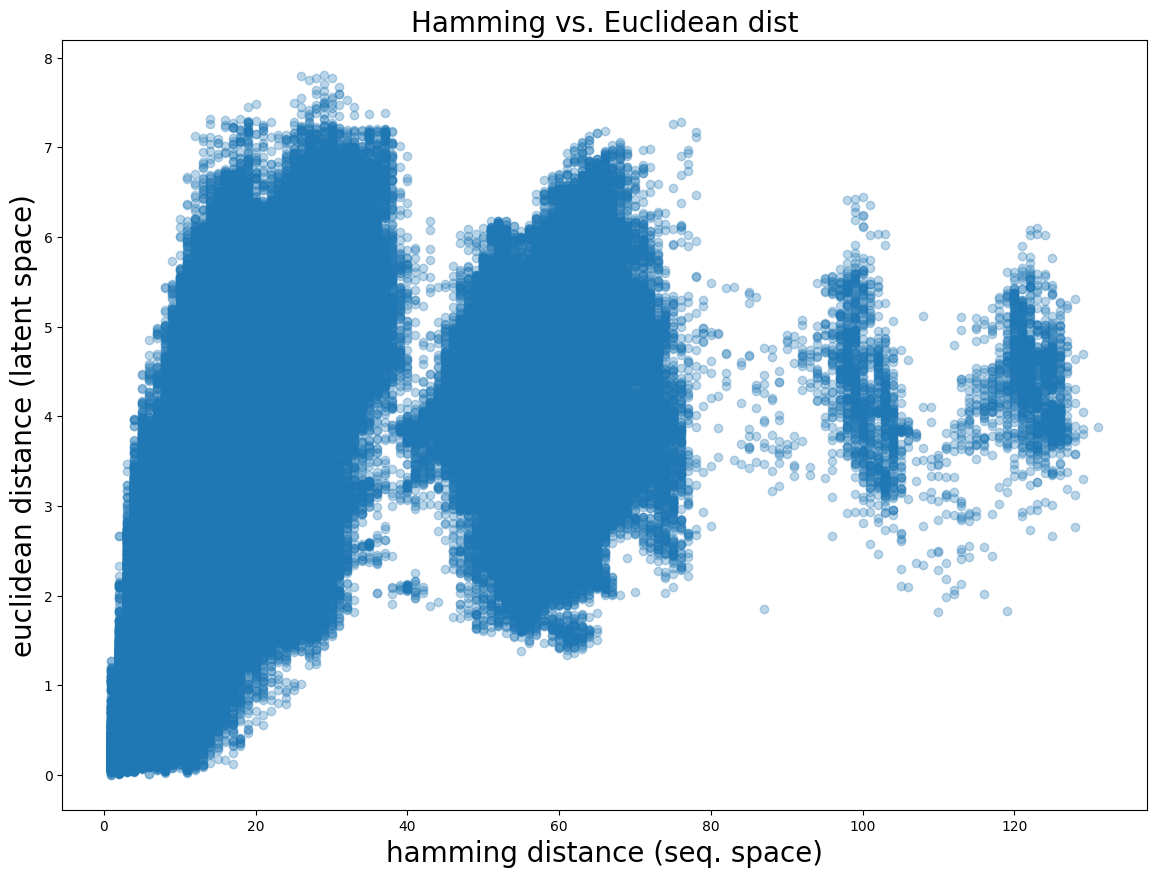

In [58]:
fig,arr = plt.subplots(1,1,figsize=(14,10))
arr.set_title("Hamming vs. Euclidean dist", fontsize=20)
arr.scatter(hamming_dists, euclid_dists, alpha=0.3)
arr.set_xlabel("hamming distance (seq. space)", fontsize=20)
arr.set_ylabel("euclidean distance (latent space)", fontsize=20)
plt.show()

## GP regression, sampling by month

In [59]:
print(metadata.columns)

Index(['name', 'parent', 'date', 'clade_membership', 'S1_mutations'], dtype='object')


In [60]:
print(Z_embedded.shape)

(6368, 4)


In [61]:
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

coords = [(x1,x2,x3,x4,t,c) for (x1,x2,x3,x4),t,c in zip(Z_embedded, dates,clade_labels)]
coords = pd.DataFrame(data=coords, columns=["dim0","dim1","dim2","dim3","time","clade"])

In [62]:
# sample by month 
avg_coords = coords.groupby("time")[["dim0","dim1","dim2","dim3"]].median().resample("ME").median().dropna().reset_index()

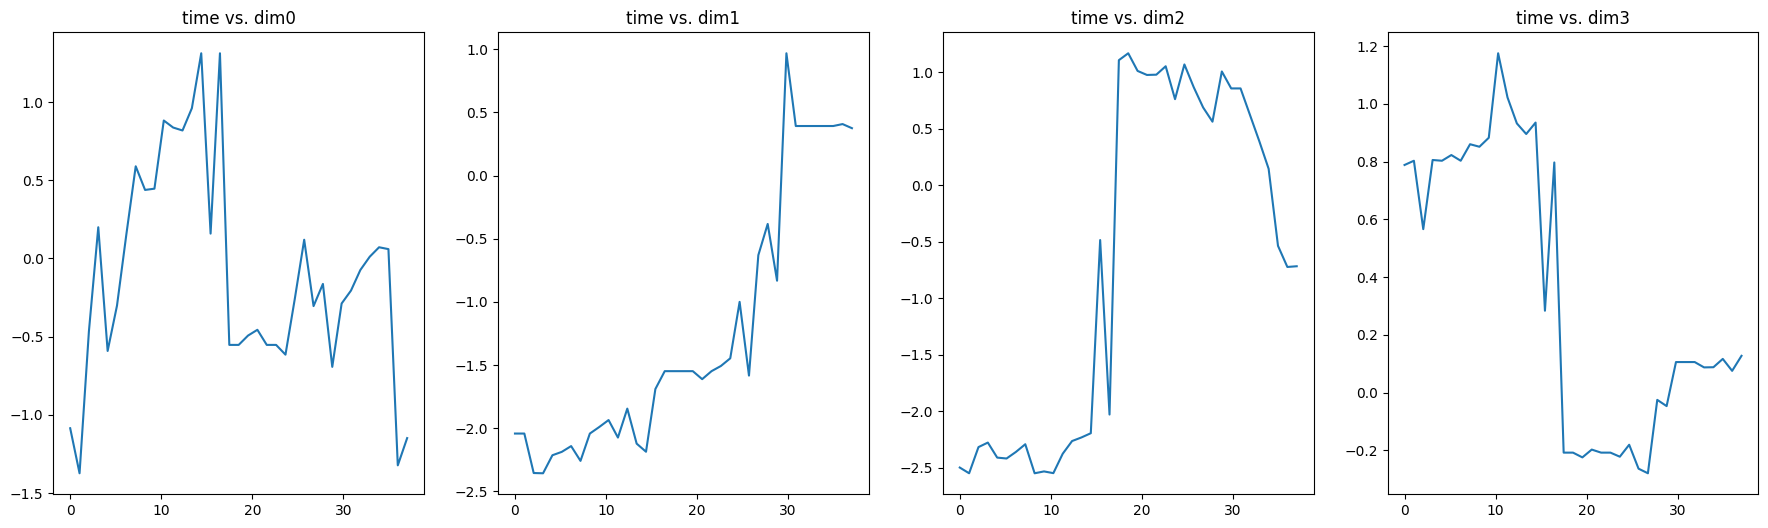

In [63]:
ubound = len(avg_coords)

plt.ioff()
fig,ax = plt.subplots(1,4,figsize=(22,6))
for i,d in enumerate(["dim0","dim1","dim2","dim3"]):
    ax[i].plot(np.linspace(0,ubound,num=len(avg_coords)), avg_coords[d])
    ax[i].set_title(f"time vs. {d}")
plt.show()

In [34]:
x_vals = np.linspace(0,ubound,num=len(avg_coords)).astype("float32")[:,np.newaxis]
# import theano.tensor as tt
def build_coords_model(dim, num_draws=2000):
    y_vals = avg_coords[dim].values.astype('float32')
    print(x_vals.shape, y_vals.shape)

    model = None
    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', np.exp(log_s2_f))
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        # Sigma = 1/lam
        s2_n = pm.HalfCauchy('s2_n', beta=5)

        gp = pm.gp.Latent(cov_func=f_cov)
        f = gp.prior("f",X=x_vals)

        df = 1 + pm.Gamma("df",alpha=2,beta=1)
        y_obs = pm.StudentT("y", mu=f, lam=1.0 / s2_n, nu=df, observed=y_vals)

        trace = pm.sample(draws=num_draws)
    return trace, gp, model

### Run and save regresssion

In [48]:
# ls = ["dim0"]

# ret_vals = [build_coords_model(d, num_draws=2000) for d in ls]

# GPs = [x[1] for x in ret_vals]
# idata = [x[0] for x in ret_vals]
# models = [x[2] for x in ret_vals]

# abspath = "."
# dict_to_save = {x:(idata[i],GPs[i]) for i,x in enumerate(["dim0","dim1","dim2"])}
# with open(f"{abspath}/king_regression_data.pkl","wb") as buff:
#     cloudpickle.dump(dict_to_save, buff)

In [47]:
for n,d in zip(ls,idata):
    print(n)
    n_nonconverged = int(
        np.sum(az.rhat(d)[["l", "log_s2_f", "s2_n", "f_rotated_", "df"]].to_array() > 1.03).values
    )
    if n_nonconverged == 0:
        print("No Rhat values above 1.03, \N{check mark}")
    else:
        print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

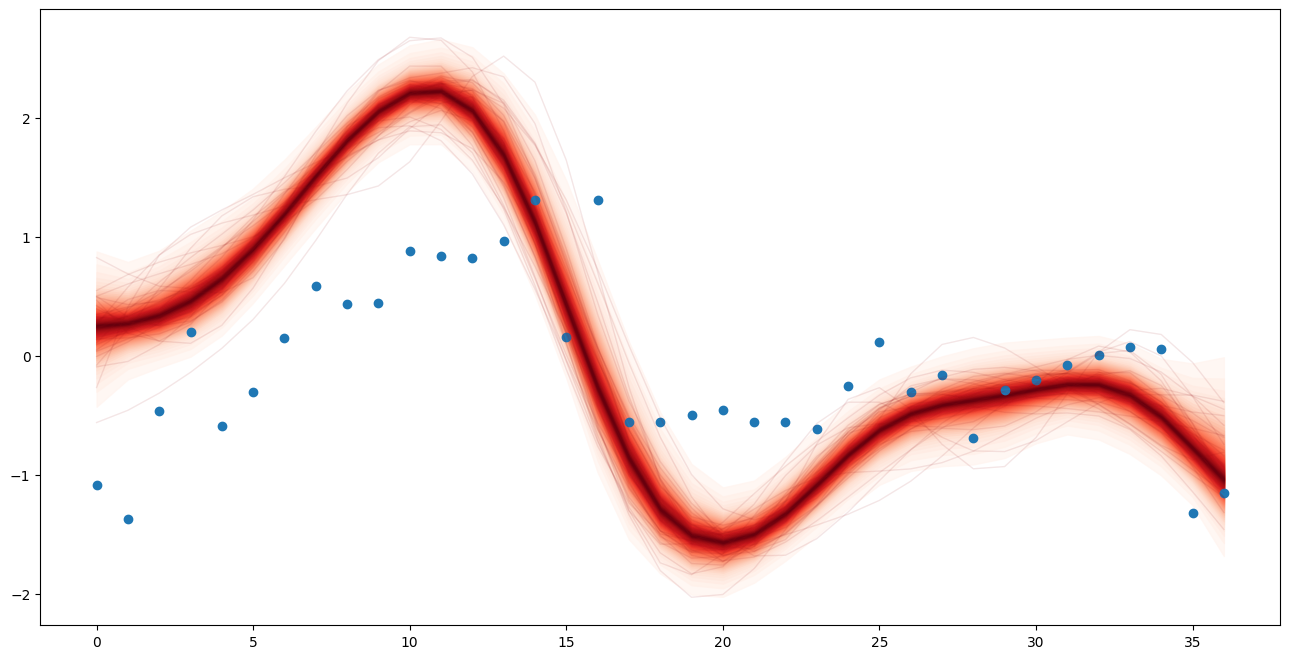

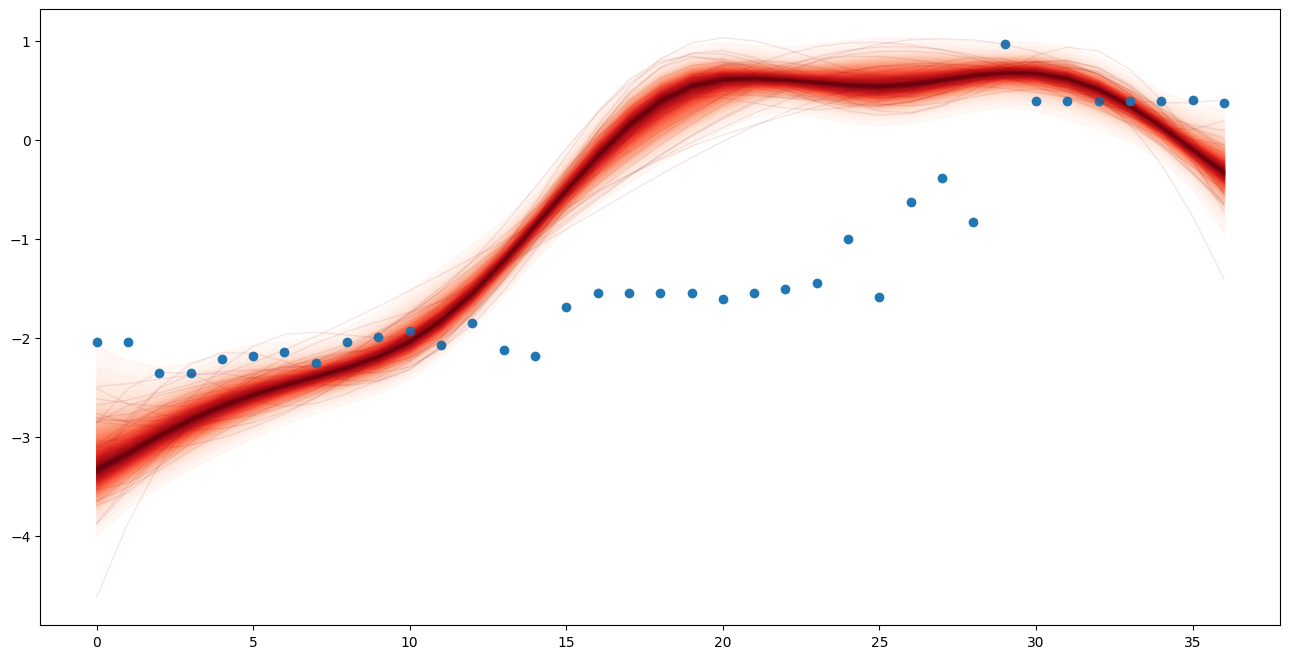

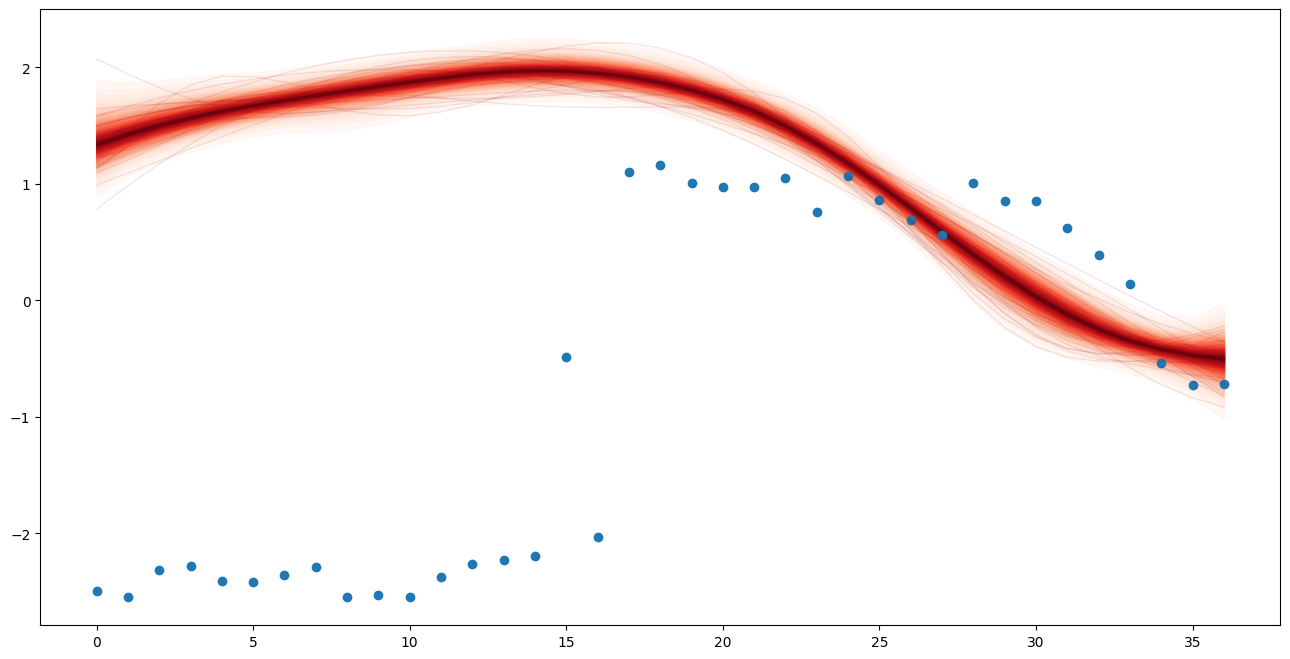

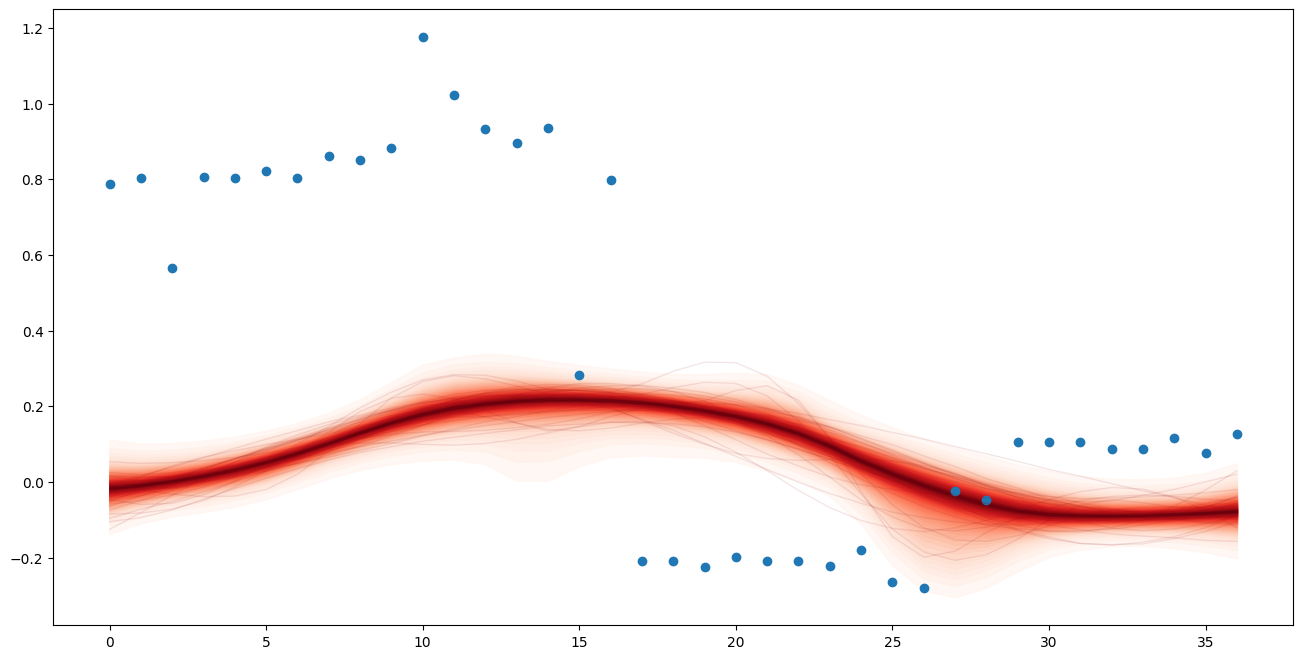

In [64]:
# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

# ls = ["dim0"]

idata = None
GPs = None
models = None
ls = ["dim0","dim1","dim2","dim3"]
with open (f"{abspath}/king_regression_data.pkl", "rb") as buff:
    ret_vals = pickle.load(buff)
    GPs = [ret_vals[x][1] for x in ls]
    idata = [ret_vals[x][0] for x in ls]
    models = [ret_vals[x][2] for x in ls]

for d,n in zip(idata,ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    disp_x_vals = np.arange(len(avg_coords))
    
    f_post = az.extract(d, var_names="f").transpose("sample", ...)
    ax = plot_gp_dist(ax, f_post, disp_x_vals)
    ax.scatter(disp_x_vals, avg_coords[n])
    plt.show()

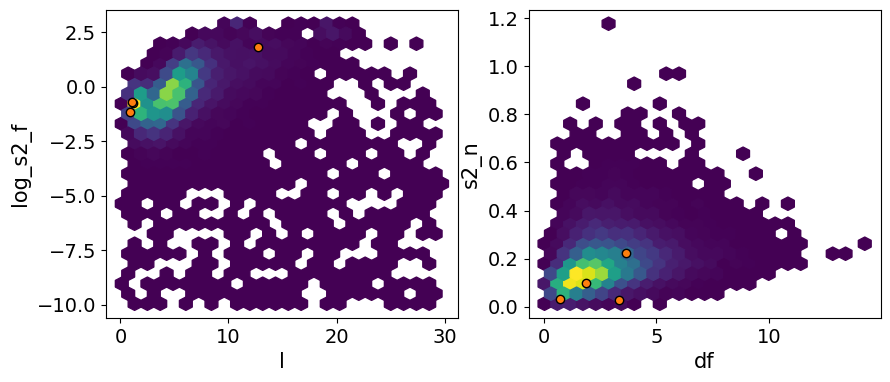

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

N = 0

# plot eta vs ell
az.plot_pair(
    idata[N],
    var_names=["l", "log_s2_f"],
    kind=["hexbin"],
    ax=axs[0],
    gridsize=25,
    divergences=True,
)
# axs[0].axvline(x=eta_true, color="dodgerblue")
# axs[0].axhline(y=ell_true, color="dodgerblue")

# plot nu vs sigma
az.plot_pair(
    idata[N],
    var_names=["df", "s2_n"],
    kind=["hexbin"],
    ax=axs[1],
    gridsize=25,
    divergences=True,
)

# axs[1].axvline(x=nu_true, color="dodgerblue")
# axs[1].axhline(y=sigma_true, color="dodgerblue");

plt.show()

In [29]:
ubound = len(avg_coords)
new_x_vals = np.linspace(-5,ubound,num=50).astype("float32")[:,np.newaxis]
x_vals = np.linspace(0,ubound,num=len(avg_coords)).astype("float32")[:,np.newaxis]
ls = ["dim0","dim1","dim2","dim3"]

pred_data = []
for N in range(len(ls)):
    print(ls[N])
    gp = GPs[N]
    dim_data = idata[N]
    with models[N]:
        # add the GP conditional to the model, given the new X values
        f_pred = gp.conditional("f_pred", new_x_vals, jitter=1e-4)
        # Sample from the GP conditional distribution
        dim_data.extend(pm.sample_posterior_predictive(dim_data, var_names=["f_pred"]))
        pred_data.append(dim_data)

dim0


Sampling: [f_pred]


dim1


Sampling: [f_pred]


dim2


Sampling: [f_pred]


In [ ]:
# train 2
# how do I know which latent space is better?

['dim0', 'dim1', 'dim2']


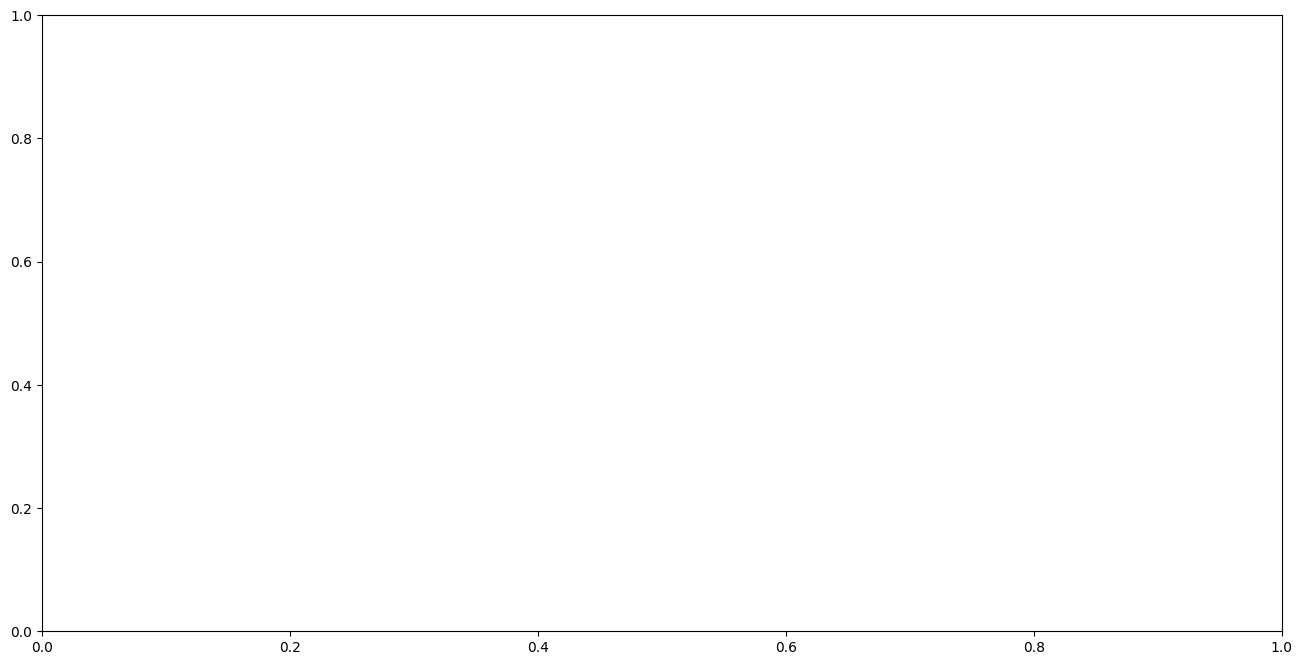

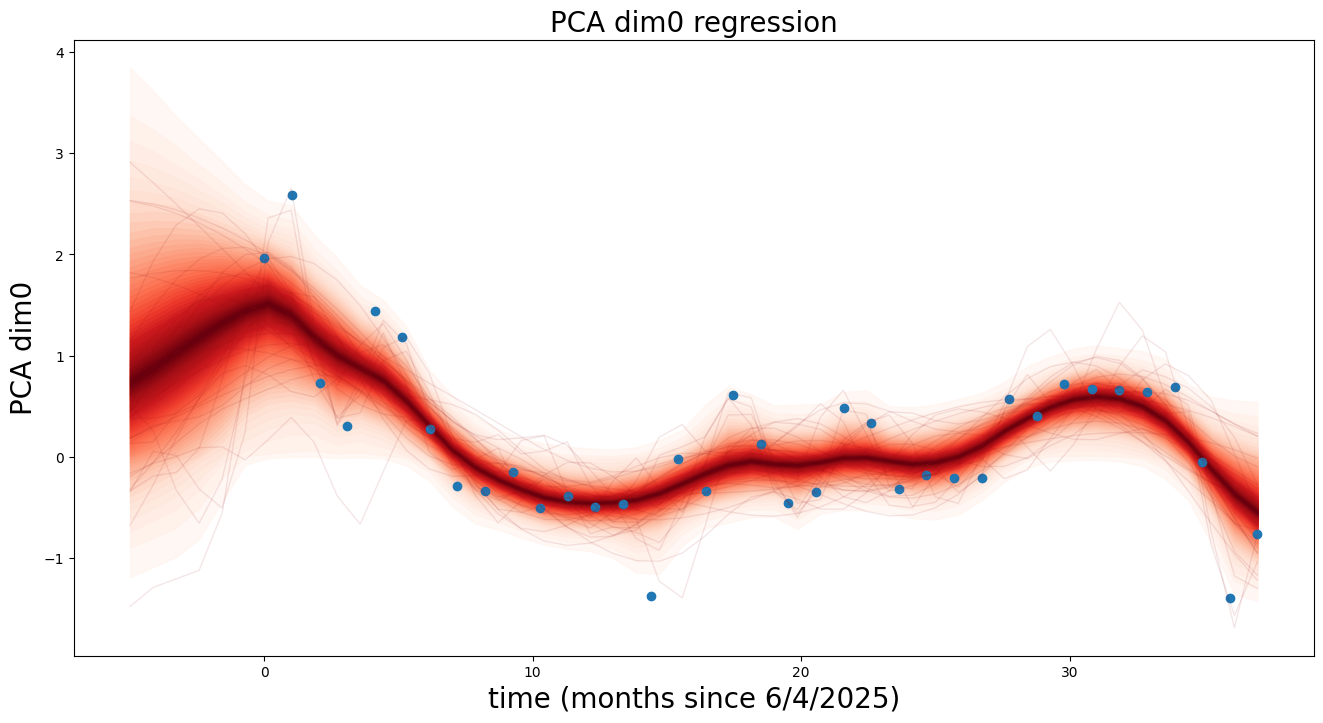

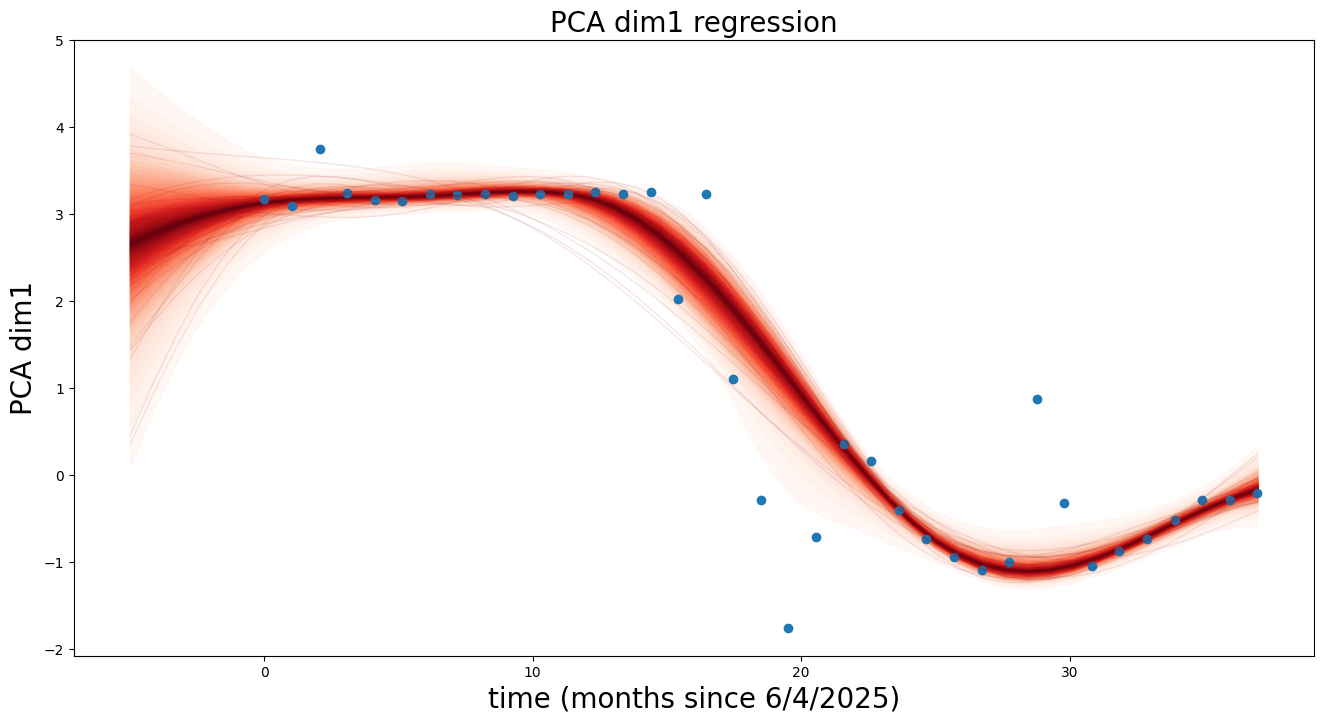

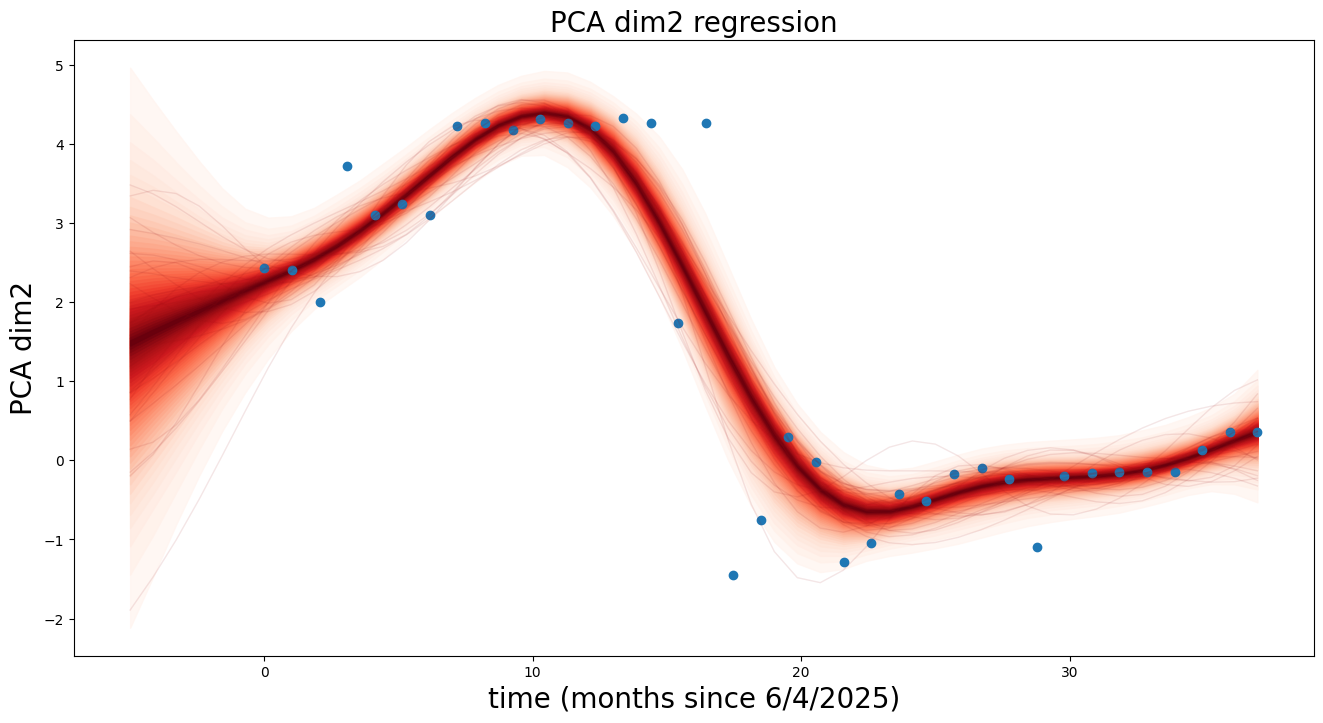

In [30]:
reg_preds = []
print(ls)
for i,n in enumerate(ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)
    reg_preds.append(f_pred)
    
    # plot_gp_dist(ax, f_post, x_vals, palette="Reds")
    ax = plot_gp_dist(ax, f_pred, new_x_vals, palette="Reds")
    ax.set_title(f"PCA {n} regression", fontsize=20)
    ax.set_xlabel("time (months since 6/4/2025)", fontsize=20)
    ax.set_ylabel(f"PCA {n}", fontsize=20)
    ax.scatter(x_vals, avg_coords[n])
    plt.show()

reg_preds = np.array(reg_preds)

## Decode into SPIKE sequences and save FASTA

In [32]:
N_seq_predict = 50

In [33]:
pred_range = (new_x_vals < 0)[:,0]
Z_regression_pred = np.copy(reg_preds)
Z_regression_pred = Z_regression_pred[:,:,pred_range]

Z_regression_pred = np.moveaxis(Z_regression_pred, 1, -1)
Z_regression_pred = np.concatenate([np.quantile(Z_regression_pred, a, axis=-1, keepdims=True) for a in [0.25,0.5,0.75]], axis=-1)

# sample = np.random.choice(Z_regression_pred.shape[-1], N_seq_predict, replace=False) # randomly sample 1000 seq.
# Z_regression_pred = Z_regression_pred[:,:,sample]
sampled_seqs = np.copy(Z_regression_pred)
Z_regression_pred = np.moveaxis(Z_regression_pred, 0, -1)

Z_regression_pred = pca.inverse_transform(Z_regression_pred) + np.mean(Z_mean.cpu().numpy())
old_shape = Z_regression_pred.shape
Z_regression_pred = Z_regression_pred.reshape((Z_regression_pred.shape[0] * Z_regression_pred.shape[1], Z_regression_pred.shape[2]))

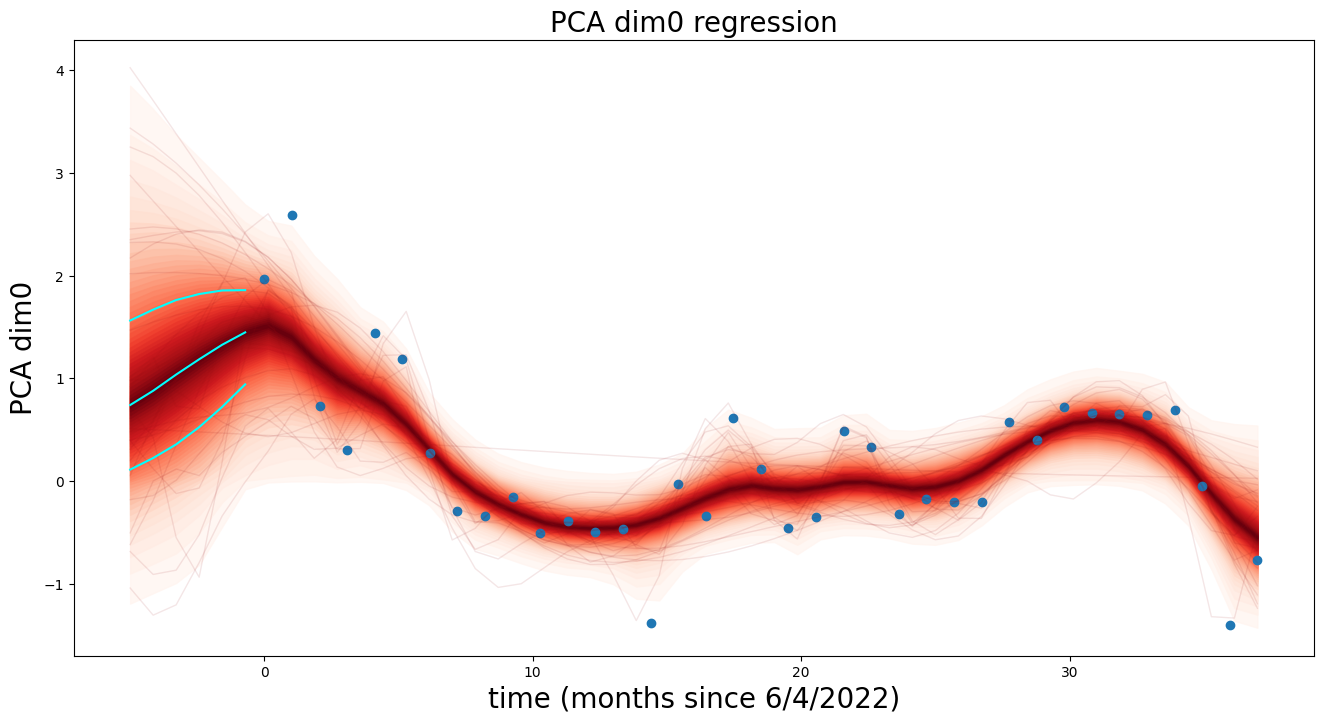

<Figure size 1600x800 with 0 Axes>

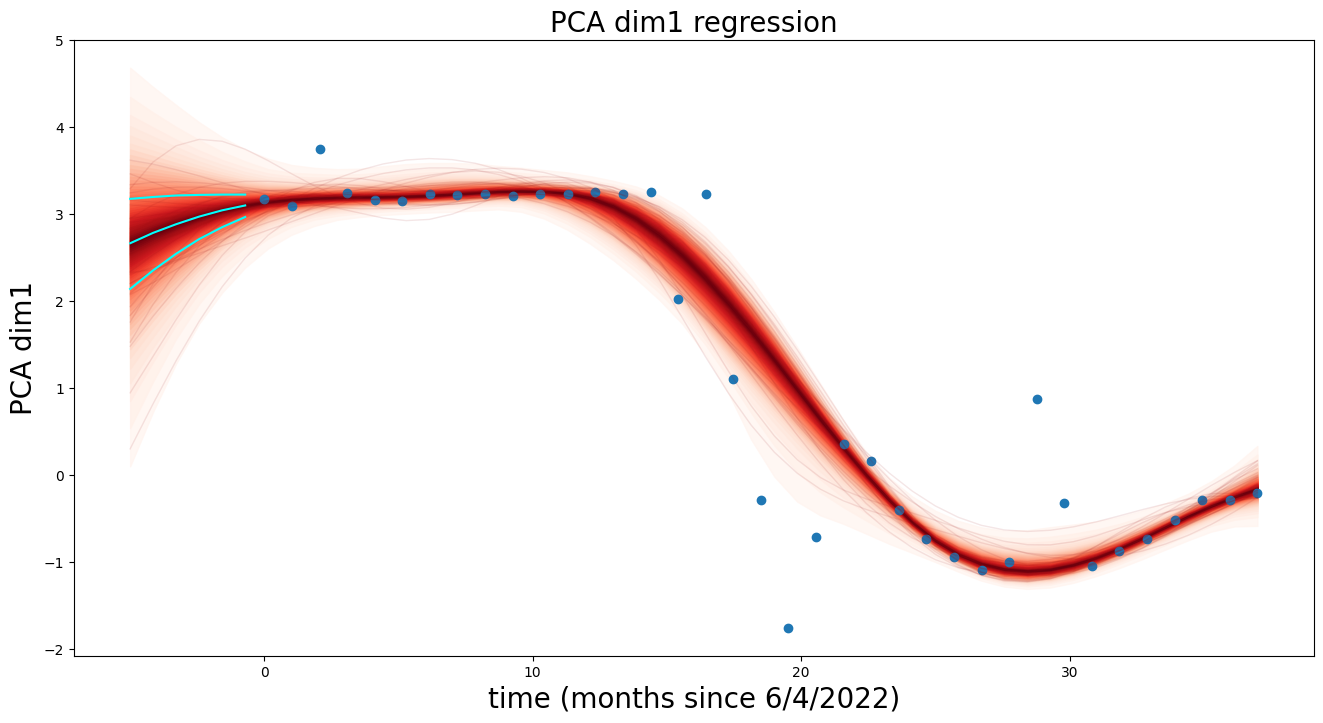

<Figure size 1600x800 with 0 Axes>

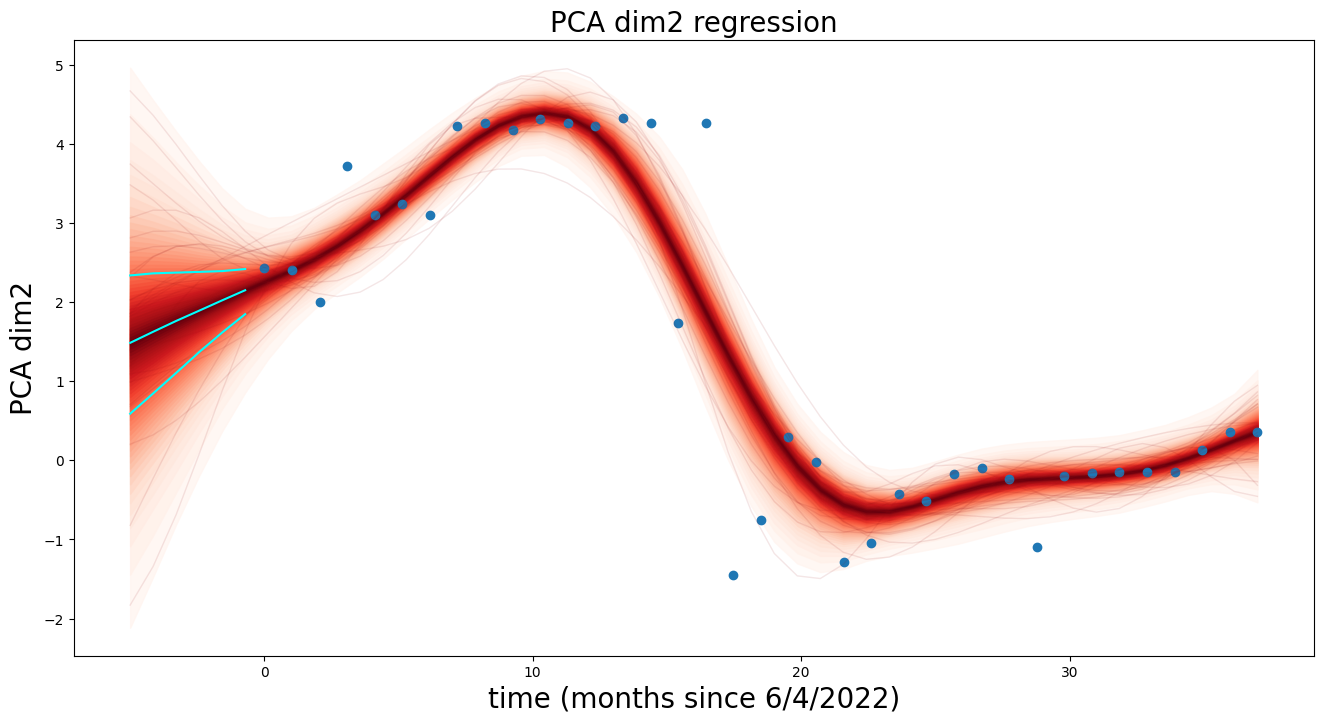

<Figure size 1600x800 with 0 Axes>

In [35]:
for i,n in enumerate(ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    ig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)

    
    ax.set_title(f"PCA {n} regression")
    ax.set_xlabel("time (months since 6/4/2025)")
    ax.set_ylabel(f"PCA {n}")
    ax = plot_gp_dist(ax, f_pred, new_x_vals, palette="Reds")
    # f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    # f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)
    # reg_preds.append(f_pred)
    
    # plot_gp_dist(ax, f_post, x_vals, palette="Reds")
    for j in range(sampled_seqs.shape[2]):
        ax.plot(new_x_vals[:6], sampled_seqs[i,:,j], c="aqua")
    ax.set_title(f"PCA {n} regression", fontsize=20)
    ax.set_xlabel("time (months since 6/4/2022)", fontsize=20)
    ax.set_ylabel(f"PCA {n}", fontsize=20)
    ax.scatter(x_vals, avg_coords[n])
    # ax.scatter(x_vals, avg_coords[n])
    plt.show()

reg_preds = np.array(reg_preds)

In [93]:
Z_regression_recon = vae_model.decoder.forward(torch.tensor(Z_regression_pred).float().to(DEVICE))
Z_regression_recon = torch.argmax(Z_regression_recon.view(old_shape[0], old_shape[1], -1, 5), dim=-1).cpu().detach().numpy()
old_shape = Z_regression_recon.shape

In [94]:
converter = np.vectorize(lambda x: ALPHABET[int(x)])
Z_regression_recon = converter(Z_regression_recon.ravel()).reshape(old_shape)

In [96]:
print(Z_regression_recon.shape)

(6, 3, 3822)


In [100]:
names = ["1q","2q","3q"]
for i,n in zip(range(Z_regression_recon.shape[1]), names):
    print(".",end="")
    with open(f"regression_recons_{n}.fasta","w") as f:
        for j in range(Z_regression_recon.shape[0]):
            f.write(f">RECON_{i}_{j}\n")
            f.write("".join(Z_regression_recon[j,i,:]))
            f.write("\n")
    print("done!")

.done!
.done!
.done!
